# Polyphase Channelizer Reference Implementation
## For MDT (FunCube+) and Haifuraiya (Opulent Voice)

**Open Research Institute**  
**Authors**: Abraxas3d and JayFeather3d, with help from Claude  
**Date**: January 2025  
**Hardware Target**: iCE40 Ultra Plus + STM32H7 (Martin Ling's board)  
**Reference Repo**: https://github.com/martinling/dynamic-transponder  
**Model Repo**: https://github.com/OpenResearchInstitute/Mode-Dynamic-Transponder   

## Purpose
This notebook provides a **parameterized Python reference implementation** of a polyphase channelizer suitable for two different applications:
1. **MDT (Mode Dynamic Transponder)** - Spectrum analyzer for FunCube+ linear transponder
2. **Haifuraiya** - Communications channelizer for Opulent Voice FDMAThe same core architecture works for both, with different parameters and filter designs.

---

## Key Design Decisions

### MDT (Spectrum Analyzer Mode)
- **Goal**: Monitor 30 kHz passband, detect SSB/CW signals anywhere
- **Input**: Complex I/Q at 40 ksps
- **Channels**: 4 (3 active for 30 kHz passband)
- **Channel bandwidth**: 10 kHz
- **Overlap**: -3 dB at channel edges (no gaps in coverage)
- **Stopband**: ~40 dB (tradeoff for proper overlap)

### Haifuraiya (Communications Mode)
- **Goal**: Receive 64 Opulent Voice channels with guard bands
- **Input**: Complex I/Q at 10 Msps
- **Channels**: 64
- **Channel bandwidth**: 156.25 kHz
- **Overlap**: None (guard bands between channels)
- **Stopband**: 60+ dB (clean channel separation)

In [19]:
import numpy as np
from scipy import signal
from scipy.fft import fft, ifft
import matplotlib.pyplot as plt
from dataclasses import dataclass, field
from typing import Optional, Tuple, List, Dict
from enum import Enum

# Make plots look nice
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print("Libraries loaded successfully!")


Libraries loaded successfully!


---
## Part 1: Configuration Classes
### Channelizer StylesThere are two fundamentally different approaches to channelizer design:

**SPECTRUM_ANALYZER**: Channels overlap at -3 dB points- No gaps in frequency coverage- Signals at channel edges appear in both adjacent channels- Use when you don't control signal placement (linear transponder)

**COMMUNICATIONS**: Channels have guard bands- Clean separation between channels- Signals must be placed at channel centers- Use when you control signal placement (FDMA protocol)

In [20]:
class ChannelizerStyle(Enum):
    """
    Channelizer design philosophy - determines filter overlap behavior.
    
    SPECTRUM_ANALYZER:
        - Channels overlap at -3 dB points
        - No frequency gaps - every Hz is covered
        - Signals at edges appear in both adjacent channels
        - Lower stopband rejection (~40 dB)
        - Use for: MDT, linear transponders, signal hunting
        
    COMMUNICATIONS:
        - Guard bands between channels
        - Signals must be placed at channel centers
        - Clean channel separation, no ambiguity
        - Higher stopband rejection (60+ dB)
        - Use for: Haifuraiya, FDMA protocols, Opulent Voice
    """
    SPECTRUM_ANALYZER = "spectrum_analyzer"
    COMMUNICATIONS = "communications"


# Filter parameters for each style
# These factors are relative to (channel_bw / 2), i.e., half the channel spacing
FILTER_PARAMS = {
    ChannelizerStyle.SPECTRUM_ANALYZER: {
        'passband_factor': 0.95,   # Passband extends to 95% of half-channel (4.75 kHz for 10 kHz channels)
        'stopband_factor': 1.15,   # Stopband begins at 115% of half-channel (5.75 kHz)
        'description': '-3dB crossover at channel edges, no frequency gaps'
    },
    ChannelizerStyle.COMMUNICATIONS: {
        'passband_factor': 0.80,   # Passband extends to 80% of half-channel
        'stopband_factor': 1.00,   # Stopband begins at half-channel (channel edge)
        'description': 'Guard bands between channels, clean separation'
    }
}

print("Channelizer styles defined:")
for style, params in FILTER_PARAMS.items():
    print(f"  {style.value}: {params['description']}")


Channelizer styles defined:
  spectrum_analyzer: -3dB crossover at channel edges, no frequency gaps
  communications: Guard bands between channels, clean separation


### Configuration DataclassAll system parameters in one place. Change values here, everything updates.

In [21]:
@dataclass
class ChannelizerConfig:
    """
    Configuration for the polyphase channelizer.
    
    This is the single source of truth for all system parameters.
    Like a character sheet for our DSP module.
    """
    # === Core Parameters ===
    name: str = "MDT"                # Configuration name
    fs_input: float = 40000.0        # Input sample rate (Hz) - complex I/Q
    num_channels: int = 4            # Number of output channels (FFT size)
    passband_hz: float = 30000.0     # Desired passband to monitor (Hz)
    
    # === Filter Parameters ===
    prototype_taps: int = 64         # Total taps in prototype filter
    channelizer_style: ChannelizerStyle = ChannelizerStyle.SPECTRUM_ANALYZER
    
    # === Fixed-Point Parameters (for FPGA) ===
    data_width: int = 16             # I/Q sample width (bits)
    coeff_width: int = 16            # Filter coefficient width (bits)
    accum_width: int = 32            # Accumulator width (bits)
    
    # === Derived Properties ===
    @property
    def fs_output(self) -> float:
        """Output sample rate per channel (Hz)."""
        return self.fs_input / self.num_channels
    
    @property
    def channel_bw(self) -> float:
        """Bandwidth per channel (Hz)."""
        return self.fs_input / self.num_channels
    
    @property
    def taps_per_phase(self) -> int:
        """Taps in each polyphase branch."""
        return self.prototype_taps // self.num_channels
    
    @property
    def filter_params(self) -> Dict:
        """Get filter design parameters based on channelizer style."""
        return FILTER_PARAMS[self.channelizer_style]
    
    @property
    def oversampling(self) -> float:
        """Oversampling factor relative to passband."""
        return self.fs_input / self.passband_hz
    
    @property 
    def channel_centers(self) -> List[float]:
        """
        Channel center frequencies (Hz) for complex I/Q input.
        
        Channels wrap around at fs/2, so upper channels represent
        negative frequencies.
        """
        centers = []
        for ch in range(self.num_channels):
            f = ch * self.channel_bw
            if f >= self.fs_input / 2:
                f -= self.fs_input  # Wrap to negative frequency
            centers.append(f)
        return centers
    
    def __post_init__(self):
        assert self.prototype_taps % self.num_channels == 0, \
            f"prototype_taps ({self.prototype_taps}) must be divisible by num_channels ({self.num_channels})"
    
    def summary(self):
        """Print configuration summary."""
        print(f"=== {self.name} Channelizer Configuration ===")
        print(f"Input sample rate:  {self.fs_input/1000:.1f} ksps (complex I/Q)")
        print(f"Passband:           {self.passband_hz/1000:.1f} kHz")
        print(f"Number of channels: {self.num_channels}")
        print(f"Channel bandwidth:  {self.channel_bw/1000:.2f} kHz")
        print(f"Output rate/ch:     {self.fs_output/1000:.2f} ksps")
        print(f"Oversampling:       {self.oversampling:.2f}×")
        print(f"Prototype taps:     {self.prototype_taps} ({self.taps_per_phase} per branch)")
        print(f"")
        print(f"Channelizer style:  {self.channelizer_style.value}")
        params = self.filter_params
        print(f"  Passband factor:  {params['passband_factor']*100:.0f}%")
        print(f"  Stopband factor:  {params['stopband_factor']*100:.0f}%")
        print(f"  {params['description']}")
        print(f"")
        print(f"Channel centers: {[f'{f/1000:+.2f} kHz' for f in self.channel_centers]}")


---
## Part 2: MDT ConfigurationThe MDT monitors a 30 kHz passband on the FunCube+ UHF uplink. We use:
- **40 ksps complex I/Q** (33% oversampling for filter headroom)
- **4 channels** at 10 kHz each
- **Spectrum analyzer style** (no gaps in coverage)With complex I/Q input, the 30 kHz passband spans -15 to +15 kHz around DC.Three channels (0, 1, 3) cover this range with proper overlap.

In [22]:
# MDT Configuration for FunCube+ Linear Transponder
mdt_config = ChannelizerConfig(
    name="MDT",
    fs_input=40000.0,           # 40 ksps complex I/Q
    num_channels=4,             # 4 channels, 3 active for passband
    passband_hz=30000.0,        # 30 kHz passband (-15 to +15 kHz)
    prototype_taps=64,          # 16 taps per polyphase branch
    channelizer_style=ChannelizerStyle.SPECTRUM_ANALYZER,
    data_width=16,
    coeff_width=16,
    accum_width=32,
)

mdt_config.summary()


=== MDT Channelizer Configuration ===
Input sample rate:  40.0 ksps (complex I/Q)
Passband:           30.0 kHz
Number of channels: 4
Channel bandwidth:  10.00 kHz
Output rate/ch:     10.00 ksps
Oversampling:       1.33×
Prototype taps:     64 (16 per branch)

Channelizer style:  spectrum_analyzer
  Passband factor:  95%
  Stopband factor:  115%
  -3dB crossover at channel edges, no frequency gaps

Channel centers: ['+0.00 kHz', '+10.00 kHz', '-20.00 kHz', '-10.00 kHz']


---
## Part 3: Haifuraiya Configuration

Haifuraiya receives Opulent Voice signals (81 kHz MSK) in a 10 MHz allocation.We use

- **10 Msps complex I/Q**
- **64 channels** at 156.25 kHz each
- **Communications style** (guard bands for Doppler margin)The 64-channel design provides 37.6 kHz guard band per side, accommodatingLEO Doppler shift (±10 kHz at 10 GHz) and station timing errors.

In [23]:
# Haifuraiya Configuration for Opulent Voice
# Note: 24 taps/branch gives <0.5 dB ripple with >60 dB stopband
#       32 taps/branch gives <0.1 dB ripple with >75 dB stopband (ideal)
haifuraiya_config = ChannelizerConfig(
    name="Haifuraiya",
    fs_input=10_000_000.0,      # 10 Msps complex I/Q
    num_channels=64,            # 64 channels for FDMA
    passband_hz=10_000_000.0,   # Full 10 MHz allocation
    prototype_taps=64 * 24,     # 1536 taps (24 per branch) for <0.5dB ripple, >60dB stopband
    channelizer_style=ChannelizerStyle.COMMUNICATIONS,
    data_width=16,
    coeff_width=16,
    accum_width=40,             # Wider accumulator for more taps
)

haifuraiya_config.summary()

print(f"")
print(f"Opulent Voice signal: 81 kHz null-to-null")
print(f"Signal as % of channel: {81e3 / haifuraiya_config.channel_bw * 100:.1f}%")
print(f"Guard band per side: {(haifuraiya_config.channel_bw - 81e3) / 2 / 1000:.1f} kHz")


=== Haifuraiya Channelizer Configuration ===
Input sample rate:  10000.0 ksps (complex I/Q)
Passband:           10000.0 kHz
Number of channels: 64
Channel bandwidth:  156.25 kHz
Output rate/ch:     156.25 ksps
Oversampling:       1.00×
Prototype taps:     1536 (24 per branch)

Channelizer style:  communications
  Passband factor:  80%
  Stopband factor:  100%
  Guard bands between channels, clean separation

Channel centers: ['+0.00 kHz', '+156.25 kHz', '+312.50 kHz', '+468.75 kHz', '+625.00 kHz', '+781.25 kHz', '+937.50 kHz', '+1093.75 kHz', '+1250.00 kHz', '+1406.25 kHz', '+1562.50 kHz', '+1718.75 kHz', '+1875.00 kHz', '+2031.25 kHz', '+2187.50 kHz', '+2343.75 kHz', '+2500.00 kHz', '+2656.25 kHz', '+2812.50 kHz', '+2968.75 kHz', '+3125.00 kHz', '+3281.25 kHz', '+3437.50 kHz', '+3593.75 kHz', '+3750.00 kHz', '+3906.25 kHz', '+4062.50 kHz', '+4218.75 kHz', '+4375.00 kHz', '+4531.25 kHz', '+4687.50 kHz', '+4843.75 kHz', '-5000.00 kHz', '-4843.75 kHz', '-4687.50 kHz', '-4531.25 kHz', '-4

---
## Part 4: Select Active Configuration

Choose which configuration to use for the rest of the notebook.

In [24]:
# === SELECT ACTIVE CONFIGURATION ===
# Change this to switch between MDT and Haifuraiya

config = mdt_config  # mdt_config or haifuraiya_config

print(f"Active configuration: {config.name}")
print(f"Channelizer style: {config.channelizer_style.value}")


Active configuration: MDT
Channelizer style: spectrum_analyzer


---
## Part 5: Prototype Filter Design

The prototype filter is a lowpass filter that defines the channel shape. Its coefficients are distributed across the polyphase branches.The filter parameters (passband/stopband edges) depend on the channelizer style:

- **SPECTRUM_ANALYZER**: Wide passband for -3dB overlap
- **COMMUNICATIONS**: Narrower passband for guard bands

In [25]:
def design_prototype_filter(config: ChannelizerConfig, 
                           method: str = 'remez',
                           verbose: bool = True) -> np.ndarray:
    """
    Design the prototype lowpass filter for the polyphase channelizer.
    
    Args:
        config: Channelizer configuration
        method: 'remez' for Parks-McClellan, 'firwin' for windowed sinc
        verbose: Print design details
    
    Returns:
        Filter coefficients (prototype_taps length)
    """
    N = config.num_channels
    num_taps = config.prototype_taps
    params = config.filter_params
    
    # Normalized frequencies (0 to 1 = 0 to Fs/2)
    # Channel bandwidth in normalized frequency: 1/N of Nyquist = 2/N... 
    # Wait, let's be careful here.
    # 
    # Normalized freq 1.0 = fs/2 (Nyquist)
    # Channel bandwidth = fs/N
    # Channel bandwidth normalized = (fs/N) / (fs/2) = 2/N
    #
    # But we want the prototype to pass ONE channel centered at DC.
    # The channel extends from -channel_bw/2 to +channel_bw/2.
    # As a lowpass, we want to pass 0 to channel_bw/2.
    # In normalized freq: 0 to (channel_bw/2) / (fs/2) = 0 to 1/N
    
    f_pass = params['passband_factor'] / N
    f_stop = params['stopband_factor'] / N
    
    if verbose:
        print(f"Designing prototype filter ({config.channelizer_style.value} style):")
        print(f"  Passband: 0 to {f_pass:.4f} (norm) = 0 to {f_pass * config.fs_input/2 / 1000:.2f} kHz")
        print(f"  Stopband: {f_stop:.4f} to 1.0 (norm) = {f_stop * config.fs_input/2 / 1000:.2f} kHz to Nyquist")
        print(f"  Transition band: {(f_stop - f_pass) * config.fs_input/2 / 1000:.2f} kHz")
    
    if method == 'remez':
        bands = [0, f_pass, f_stop, 1.0]
        desired = [1, 0]
        
        # Weight stopband more heavily for better rejection
        # Higher weight for COMMUNICATIONS mode
        if config.channelizer_style == ChannelizerStyle.COMMUNICATIONS:
            weights = [1, 50]
        else:
            weights = [1, 10]
        
        try:
            coeffs = signal.remez(num_taps, bands, desired, weight=weights, fs=2.0)
        except Exception as e:
            print(f"Remez failed ({e}), falling back to firwin")
            method = 'firwin'
    
    if method == 'firwin':
        cutoff = (f_pass + f_stop) / 2
        coeffs = signal.firwin(num_taps, cutoff, window='blackman', fs=2.0)
    
    # Normalize for unity passband gain (0 dB at DC)
    # With unity-normalized filter and unscaled FFT, we get unity end-to-end gain.
    # This also makes the filter response plot show 0 dB in the passband.
    coeffs = coeffs / np.sum(coeffs)
    
    return coeffs


# Design filter for active configuration
prototype = design_prototype_filter(config)
print(f"\nDesigned {len(prototype)}-tap prototype filter")
print(f"DC gain: {20*np.log10(np.abs(np.sum(prototype))):.2f} dB (should be ~0 dB)")


Designing prototype filter (spectrum_analyzer style):
  Passband: 0 to 0.2375 (norm) = 0 to 4.75 kHz
  Stopband: 0.2875 to 1.0 (norm) = 5.75 kHz to Nyquist
  Transition band: 1.00 kHz

Designed 64-tap prototype filter
DC gain: -0.00 dB (should be ~0 dB)


In [26]:
def analyze_filter(coeffs: np.ndarray, config: ChannelizerConfig):
    """Analyze and display filter characteristics."""
    w, h = signal.freqz(coeffs, worN=8192, fs=config.fs_input)
    h_db = 20 * np.log10(np.abs(h) + 1e-12)
    
    # Key metrics
    channel_bw = config.channel_bw
    params = config.filter_params
    
    # Find -3dB point
    idx_3db = np.argmin(np.abs(h_db - (h_db[0] - 3)))
    freq_3db = w[idx_3db]
    
    # Find stopband attenuation at channel edge
    idx_edge = np.argmin(np.abs(w - channel_bw))
    stopband_atten = h_db[0] - h_db[idx_edge]
    
    # Passband ripple
    passband_edge = params['passband_factor'] * channel_bw / 2
    idx_pb = w <= passband_edge
    passband_ripple = np.max(h_db[idx_pb]) - np.min(h_db[idx_pb])
    
    print(f"\n=== Filter Analysis ===")
    print(f"  -3 dB point:      {freq_3db/1000:.2f} kHz")
    print(f"  Stopband atten:   {stopband_atten:.1f} dB (at channel edge)")
    print(f"  Passband ripple:  {passband_ripple:.2f} dB")
    
    return w, h_db, {'freq_3db': freq_3db, 'stopband_atten': stopband_atten, 
                     'passband_ripple': passband_ripple}

w, h_db, metrics = analyze_filter(prototype, config)



=== Filter Analysis ===
  -3 dB point:      4.94 kHz
  Stopband atten:   61.6 dB (at channel edge)
  Passband ripple:  1.01 dB


---
## Part 6: Channel Coverage Visualization

This is the key visualization showing how channels cover the passband.

For **complex I/Q input**, the frequency range is -fs/2 to +fs/2.Channels wrap around at Nyquist, so upper channel indices representnegative frequencies.

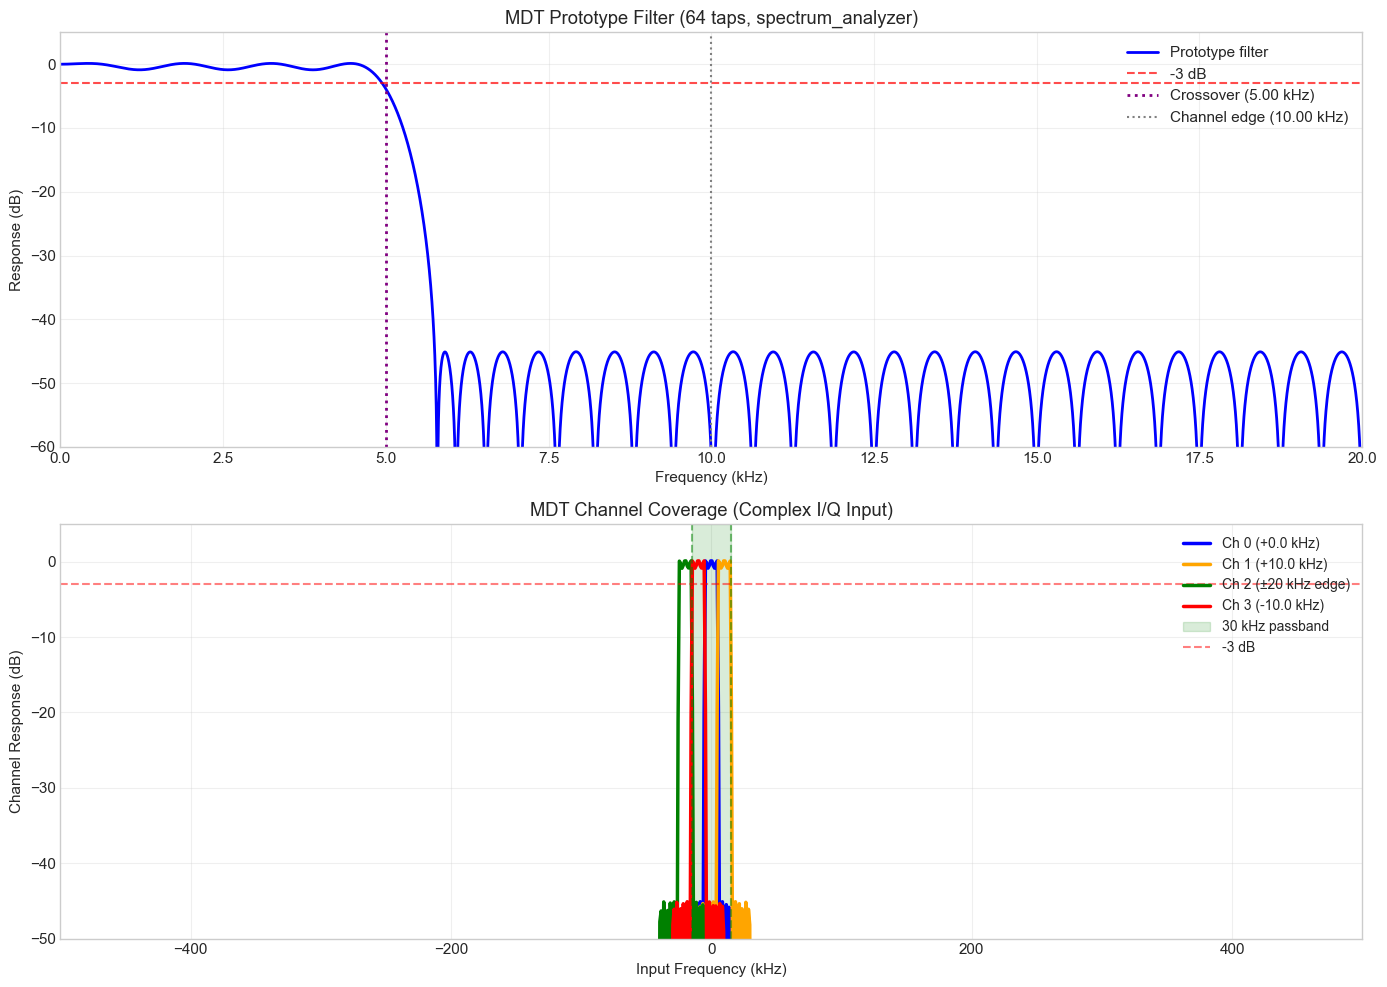


=== Channel Coverage for 30 kHz Passband ===
  Ch 0:   -5.00 to   +5.00 kHz (covers 10.0 kHz of passband) ✓
  Ch 1:   +5.00 to  +15.00 kHz (covers 10.0 kHz of passband) ✓
  Ch 2:  -25.00 to  -15.00 kHz (outside passband)
  Ch 3:  -15.00 to   -5.00 kHz (covers 10.0 kHz of passband) ✓


In [27]:
def plot_channel_coverage(coeffs: np.ndarray, config: ChannelizerConfig, 
                          freq_range: Optional[Tuple[float, float]] = None):
    """
    Visualize how channels cover the frequency range for complex I/Q input.
    
    Args:
        coeffs: Prototype filter coefficients
        config: Channelizer configuration
        freq_range: (min, max) frequency in Hz to display, or None for auto
    """
    # Get filter response
    w, h = signal.freqz(coeffs, worN=8192, fs=config.fs_input)
    h_db = 20 * np.log10(np.abs(h) + 1e-12)
    
    # Channel parameters
    channel_bw = config.channel_bw
    ch_centers = config.channel_centers
    
    # Determine frequency range to plot
    if freq_range is None:
        # Show passband plus some margin
        margin = config.passband_hz * 0.2
        freq_range = (-config.passband_hz/2 - margin, config.passband_hz/2 + margin)
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
    
    # === Plot 1: Prototype filter response ===
    ax1.plot(w/1000, h_db, 'b-', linewidth=2, label='Prototype filter')
    ax1.axhline(y=h_db[0]-3, color='r', linestyle='--', alpha=0.7, label='-3 dB')
    ax1.axvline(x=channel_bw/2/1000, color='purple', linestyle=':', linewidth=2,
                label=f'Crossover ({channel_bw/2/1000:.2f} kHz)')
    ax1.axvline(x=channel_bw/1000, color='gray', linestyle=':', 
                label=f'Channel edge ({channel_bw/1000:.2f} kHz)')
    
    ax1.set_xlim([0, min(config.fs_input/2/1000, channel_bw*2/1000)])
    ax1.set_ylim([h_db[0]-60, h_db[0]+5])
    ax1.set_xlabel('Frequency (kHz)')
    ax1.set_ylabel('Response (dB)')
    ax1.set_title(f'{config.name} Prototype Filter ({config.prototype_taps} taps, {config.channelizer_style.value})')
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)
    
    # === Plot 2: All channels for complex I/Q ===
    # Use distinct colors for each channel
    colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray']
    
    # Generate frequency points for plotting
    freq_points = np.linspace(freq_range[0], freq_range[1], 1000)
    
    # Nyquist frequency
    f_nyquist = config.fs_input / 2
    
    for ch in range(config.num_channels):
        ch_center = ch_centers[ch]
        responses = []
        
        # Determine if this channel is at the Nyquist edge
        is_nyquist_edge = abs(abs(ch_center) - f_nyquist) < 1  # Within 1 Hz of Nyquist
        
        for f in freq_points:
            # Distance from channel center (prototype is symmetric)
            f_rel = abs(f - ch_center)
            
            # For Nyquist edge channel, only show on ONE side to avoid duplicate
            # Show it on the negative side (where ch_center is)
            if is_nyquist_edge and f > 0:
                responses.append(-100)
                continue
            
            if f_rel <= f_nyquist:
                idx = np.argmin(np.abs(w - f_rel))
                responses.append(h_db[idx])
            else:
                responses.append(-100)
        
        # Create label with edge notation for Nyquist channel
        if is_nyquist_edge:
            label = f'Ch {ch} (±{f_nyquist/1000:.0f} kHz edge)'
        else:
            label = f'Ch {ch} ({ch_center/1000:+.1f} kHz)'
        
        # Only show label if channel appears in plot
        if not any(r > h_db[0] - 50 for r in responses):
            label = None
            
        ax2.plot(freq_points/1000, responses, color=colors[ch % len(colors)], 
                 linewidth=2.5, label=label)
    
    # Mark passband
    pb_low = -config.passband_hz / 2
    pb_high = config.passband_hz / 2
    ax2.axvspan(pb_low/1000, pb_high/1000, alpha=0.15, color='green', 
                label=f'{config.passband_hz/1000:.0f} kHz passband')
    ax2.axvline(x=pb_low/1000, color='green', linestyle='--', alpha=0.5)
    ax2.axvline(x=pb_high/1000, color='green', linestyle='--', alpha=0.5)
    
    ax2.axhline(y=h_db[0]-3, color='r', linestyle='--', alpha=0.5, label='-3 dB')
    
    ax2.set_xlim([freq_range[0]/1000, freq_range[1]/1000])
    ax2.set_ylim([h_db[0]-50, h_db[0]+5])
    ax2.set_xlabel('Input Frequency (kHz)')
    ax2.set_ylabel('Channel Response (dB)')
    ax2.set_title(f'{config.name} Channel Coverage (Complex I/Q Input)')
    ax2.legend(loc='upper right', fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print coverage summary
    print(f"\n=== Channel Coverage for {config.passband_hz/1000:.0f} kHz Passband ===")
    for ch in range(config.num_channels):
        ch_center = ch_centers[ch]
        ch_low = ch_center - channel_bw/2
        ch_high = ch_center + channel_bw/2
        
        # Check if channel covers part of passband
        if ch_high > pb_low and ch_low < pb_high:
            overlap_low = max(ch_low, pb_low)
            overlap_high = min(ch_high, pb_high)
            coverage = (overlap_high - overlap_low) / 1000
            print(f"  Ch {ch}: {ch_low/1000:+7.2f} to {ch_high/1000:+7.2f} kHz "
                  f"(covers {coverage:.1f} kHz of passband) ✓")
        else:
            print(f"  Ch {ch}: {ch_low/1000:+7.2f} to {ch_high/1000:+7.2f} kHz "
                  f"(outside passband)")


# Plot channel coverage for active configuration
#plot_channel_coverage(prototype, config, (-500000,500000)) # easier to see for Haifuraiya
plot_channel_coverage(prototype, config) # use this for mdt


---
## Part 7: Polyphase Decomposition

The prototype filter coefficients are distributed across N branches usingthe "card dealing" pattern. This is the key to the computational efficiencyof the polyphase channelizer.

In [28]:
def decompose_polyphase(prototype: np.ndarray, num_channels: int) -> np.ndarray:
    """
    Distribute prototype filter coefficients across polyphase branches.
    
    The coefficients are dealt round-robin like cards:
    - Branch 0 gets: h[0], h[4], h[8], ...
    - Branch 1 gets: h[1], h[5], h[9], ...
    - etc.
    
    Args:
        prototype: Full prototype filter coefficients
        num_channels: Number of channels/branches (N)
    
    Returns:
        Polyphase matrix of shape (num_channels, taps_per_branch)
        Row k contains coefficients for branch k
    """
    taps_per_branch = len(prototype) // num_channels
    
    # Reshape and transpose: the "card dealing"
    polyphase = prototype.reshape(taps_per_branch, num_channels).T
    
    return polyphase


# Decompose prototype into polyphase branches
polyphase = decompose_polyphase(prototype, config.num_channels)

print(f"Polyphase decomposition:")
print(f"  Prototype: {len(prototype)} taps")
print(f"  Branches:  {polyphase.shape[0]}")
print(f"  Taps/branch: {polyphase.shape[1]}")
print(f"  Matrix shape: {polyphase.shape}")


Polyphase decomposition:
  Prototype: 64 taps
  Branches:  4
  Taps/branch: 16
  Matrix shape: (4, 16)


---
## Part 8: Polyphase Channelizer Implementation

This class implements the polyphase channelizer that processes samples one at a time, matching the VHDL architecture.

In [29]:
class PolyphaseChannelizer:
    """
    Polyphase channelizer implementation.
    
    Processes one sample at a time, producing N channel outputs
    every N input samples. This matches the VHDL architecture.
    """
    
    def __init__(self, config: ChannelizerConfig, polyphase_coeffs: np.ndarray):
        self.config = config
        self.coeffs = polyphase_coeffs
        self.N = config.num_channels
        self.M = config.taps_per_phase
        
        # Delay lines (one per branch)
        self.delay_lines = np.zeros((self.N, self.M), dtype=complex)
        
        # Input phase counter
        self.input_phase = 0
        
        # Statistics
        self.samples_processed = 0
        self.outputs_produced = 0
    
    def reset(self):
        """Reset all state."""
        self.delay_lines.fill(0)
        self.input_phase = 0
        self.samples_processed = 0
        self.outputs_produced = 0
    
    def process_sample(self, sample: complex) -> Optional[np.ndarray]:
        """
        Process one input sample.
        
        Returns None while accumulating, or array of N channel outputs when ready.
        """
        # Shift delay line and insert new sample
        self.delay_lines[self.input_phase] = np.roll(self.delay_lines[self.input_phase], 1)
        self.delay_lines[self.input_phase, 0] = sample
        
        self.samples_processed += 1
        self.input_phase = (self.input_phase + 1) % self.N
        
        # Output ready when we've collected N samples
        if self.input_phase == 0:
            return self._compute_outputs()
        return None
    
    def _compute_outputs(self) -> np.ndarray:
        """Compute channel outputs from current state."""
        # Step 1: Polyphase filtering
        filter_outputs = np.sum(self.coeffs * self.delay_lines, axis=1)
        
        # Step 2: N-point FFT (unscaled)
        # With unity-normalized filter (sum=1), unscaled FFT gives unity end-to-end gain
        channel_outputs = fft(filter_outputs)
        
        self.outputs_produced += 1
        return channel_outputs
    
    def process_block(self, samples: np.ndarray) -> np.ndarray:
        """Process a block of samples, return all channel outputs."""
        outputs = []
        for sample in samples:
            result = self.process_sample(sample)
            if result is not None:
                outputs.append(result)
        
        if len(outputs) == 0:
            return np.array([]).reshape(0, self.N)
        return np.array(outputs)


# Create channelizer instance
channelizer = PolyphaseChannelizer(config, polyphase)
print(f"Channelizer created: {config.num_channels} channels, {config.taps_per_phase} taps/branch")


Channelizer created: 4 channels, 16 taps/branch


---
## Part 9: Test Signal Generation

Generate test signals to verify the channelizer works correctly.

In [30]:
def generate_test_tone(frequency: float, duration: float, fs: float, 
                       amplitude: float = 1.0) -> np.ndarray:
    """Generate a complex sinusoid at the specified frequency."""
    t = np.arange(int(duration * fs)) / fs
    return amplitude * np.exp(2j * np.pi * frequency * t)


def generate_multi_tone(frequencies: List[float], duration: float, fs: float,
                        amplitudes: Optional[List[float]] = None) -> np.ndarray:
    """Generate sum of complex sinusoids."""
    if amplitudes is None:
        amplitudes = [1.0] * len(frequencies)
    
    signal = np.zeros(int(duration * fs), dtype=complex)
    for freq, amp in zip(frequencies, amplitudes):
        signal += generate_test_tone(freq, duration, fs, amp)
    
    return signal


# Test: Generate tone at 5 kHz and process through channelizer
test_freq = 5000  # Hz
test_duration = 0.1  # seconds
test_signal = generate_test_tone(test_freq, test_duration, config.fs_input)

channelizer.reset()
outputs = channelizer.process_block(test_signal)

print(f"Test signal: {test_freq/1000:.1f} kHz tone, {test_duration*1000:.0f} ms")
print(f"Input samples: {len(test_signal)}")
print(f"Output frames: {len(outputs)}")
print()

# Show power in each channel
power_per_ch = np.mean(np.abs(outputs)**2, axis=0)
power_db = 10 * np.log10(power_per_ch + 1e-12)
power_db_norm = power_db - np.max(power_db)

print("Channel power (relative to strongest):")
for ch, (center, pwr) in enumerate(zip(config.channel_centers, power_db_norm)):
    marker = "<<<" if pwr > -3 else ""
    print(f"  Ch {ch} ({center/1000:+6.1f} kHz): {pwr:+6.1f} dB {marker}")


Test signal: 5.0 kHz tone, 100 ms
Input samples: 4000
Output frames: 1000

Channel power (relative to strongest):
  Ch 0 (  +0.0 kHz):   +0.0 dB <<<
  Ch 1 ( +10.0 kHz):   +0.0 dB <<<
  Ch 2 ( -20.0 kHz):  -42.9 dB 
  Ch 3 ( -10.0 kHz):  -42.9 dB 


---

## Part 10: Multi-Frequency Test

Test with signals at different frequencies to verify channel separation.


In [31]:
# Test with multiple tones at different frequencies
test_frequencies = [
    -12000,  # Should appear in Ch 3
    -5000,   # Should appear in Ch 0/3 crossover
    0,       # DC - Ch 0
    3000,    # Ch 0
    7000,    # Ch 0/1 crossover  
    12000,   # Ch 1
]

test_signal = generate_multi_tone(test_frequencies, 0.1, config.fs_input,
                                   amplitudes=[1.0] * len(test_frequencies))

# Add some noise
noise = 0.01 * (np.random.randn(len(test_signal)) + 1j * np.random.randn(len(test_signal)))
test_signal += noise

channelizer.reset()
outputs = channelizer.process_block(test_signal)

# Analyze
power_per_ch = np.mean(np.abs(outputs)**2, axis=0)
power_db = 10 * np.log10(power_per_ch + 1e-12)

print("Multi-tone test results:")
print(f"Test frequencies: {[f/1000 for f in test_frequencies]} kHz")
print()
print("Channel power:")
for ch, (center, pwr) in enumerate(zip(config.channel_centers, power_db)):
    print(f"  Ch {ch} ({center/1000:+6.1f} kHz): {pwr:.1f} dB")


Multi-tone test results:
Test frequencies: [-12.0, -5.0, 0.0, 3.0, 7.0, 12.0] kHz

Channel power:
  Ch 0 (  +0.0 kHz): 3.8 dB
  Ch 1 ( +10.0 kHz): 1.8 dB
  Ch 2 ( -20.0 kHz): -1.7 dB
  Ch 3 ( -10.0 kHz): 0.8 dB


---

## Part 11: Coverage Verification

Sweep a tone across the passband to verify there are no gaps in coverage.
For spectrum analyzer mode, we should see smooth response everywhere.


Verifying coverage across passband (40 points)...


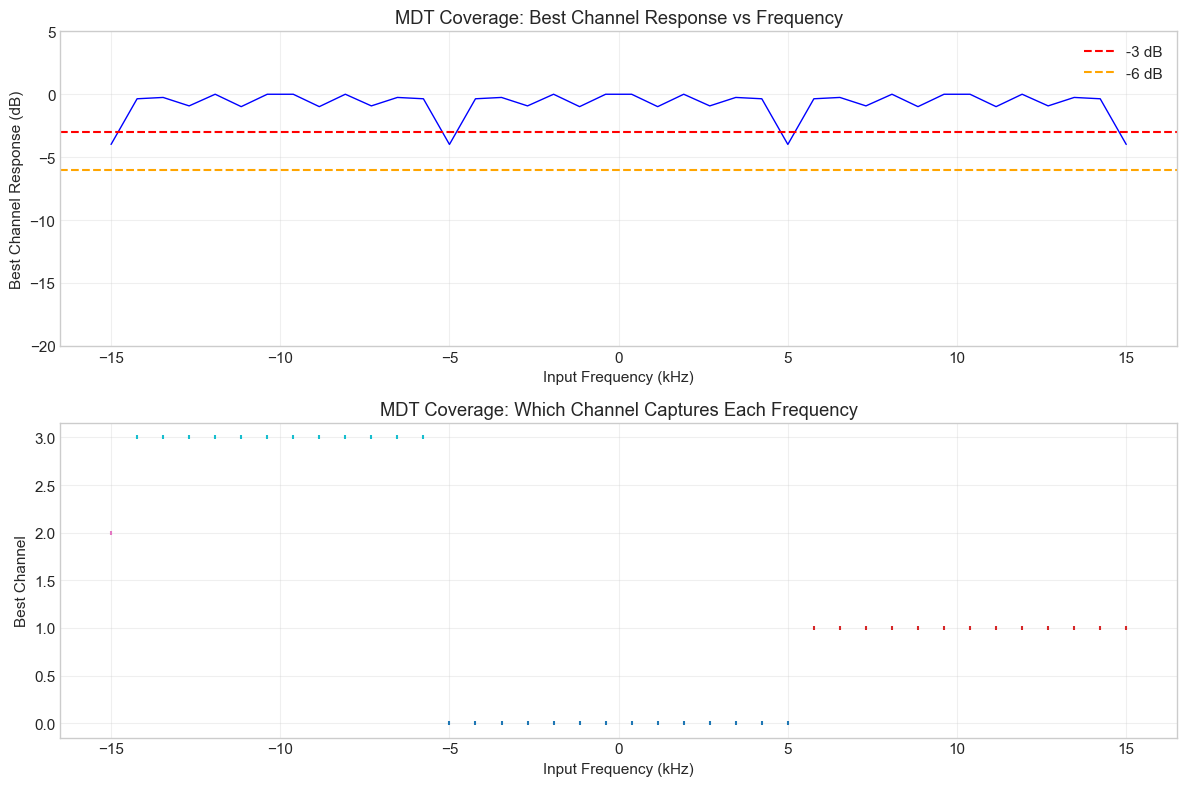


Coverage Summary:
  Worst-case response: -4.0 dB
  ✓ Good coverage - no gaps greater than 6 dB


In [32]:
def verify_coverage(config: ChannelizerConfig, prototype: np.ndarray,
                    freq_range: Optional[Tuple[float, float]] = None,
                    points_per_channel: int = 10):
    """
    Compute coverage using analytical filter response (fast!).
    
    Instead of running signals through the channelizer, this computes
    the filter response directly from the prototype coefficients.
    
    Args:
        config: Channelizer configuration
        prototype: Prototype filter coefficients (not polyphase matrix)
        freq_range: (min, max) frequency in Hz, or None for full passband
        points_per_channel: Number of test points per channel (default 10)
                           Total points = num_channels × points_per_channel
    
    Returns array of (frequency, best_channel, best_response_db)
    """
    if freq_range is None:
        freq_range = (-config.passband_hz/2, config.passband_hz/2)
    
    # Get prototype filter response (computed once)
    w, h = signal.freqz(prototype, worN=8192, fs=config.fs_input)
    h_db = 20 * np.log10(np.abs(h) + 1e-12)
    
    # Channel centers
    ch_centers = config.channel_centers
    f_nyquist = config.fs_input / 2
    
    # Scale test points with number of channels for proper resolution
    num_points = config.num_channels * points_per_channel
    test_freqs = np.linspace(freq_range[0], freq_range[1], num_points)
    results = []
    
    for freq in test_freqs:
        # Find response in each channel at this frequency
        best_response = -200
        best_ch = 0
        
        for ch in range(config.num_channels):
            ch_center = ch_centers[ch]
            # Distance from channel center
            f_rel = abs(freq - ch_center)
            
            # Handle wrap-around at Nyquist
            if f_rel > f_nyquist:
                f_rel = config.fs_input - f_rel
            
            # Look up response from prototype filter
            if f_rel <= f_nyquist:
                idx = np.argmin(np.abs(w - f_rel))
                response = h_db[idx]
                if response > best_response:
                    best_response = response
                    best_ch = ch
        
        results.append((freq, best_ch, best_response))
    
    return np.array(results)


# Run coverage verification (fast - uses analytical filter response)
print(f"Verifying coverage across passband ({config.num_channels * 10} points)...")
coverage = verify_coverage(config, prototype, points_per_channel=10)

# Plot results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

freqs = coverage[:, 0] / 1000
best_ch = coverage[:, 1].astype(int)
best_power = coverage[:, 2]

# Normalize power
best_power_norm = best_power - np.max(best_power)

# Plot 1: Best channel response vs frequency
ax1.plot(freqs, best_power_norm, 'b-', linewidth=1)
ax1.axhline(y=-3, color='r', linestyle='--', label='-3 dB')
ax1.axhline(y=-6, color='orange', linestyle='--', label='-6 dB')
ax1.set_xlabel('Input Frequency (kHz)')
ax1.set_ylabel('Best Channel Response (dB)')
ax1.set_title(f'{config.name} Coverage: Best Channel Response vs Frequency')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim([-20, 5])

# Plot 2: Which channel is best at each frequency
colors = plt.cm.tab10(np.linspace(0, 1, min(config.num_channels, 10)))
for ch in range(config.num_channels):
    mask = best_ch == ch
    if np.any(mask):
        ax2.scatter(freqs[mask], [ch]*np.sum(mask), 
                    c=[colors[ch % 10]], s=10, marker='|')

ax2.set_xlabel('Input Frequency (kHz)')
ax2.set_ylabel('Best Channel')
ax2.set_title(f'{config.name} Coverage: Which Channel Captures Each Frequency')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary - interpretation depends on channelizer style
worst_case = np.min(best_power_norm)
print(f"\nCoverage Summary:")
print(f"  Worst-case response: {worst_case:.1f} dB")

if config.channelizer_style == ChannelizerStyle.SPECTRUM_ANALYZER:
    # For spectrum analyzer, we want continuous coverage
    if worst_case > -6:
        print(f"  ✓ Good coverage - no gaps greater than 6 dB")
    else:
        print(f"  ⚠ Coverage gap detected! Consider adjusting filter parameters.")
else:
    # For communications, gaps are intentional (guard bands)
    print(f"  ✓ Guard bands present (expected for COMMUNICATIONS mode)")
    print(f"  Signals should be placed at channel centers, not edges.")


---

## Part 12: Fixed-Point Conversion for FPGA

Convert floating-point coefficients to fixed-point for VHDL implementation.


In [33]:
def float_to_fixed(values: np.ndarray, width: int, frac_bits: int) -> np.ndarray:
    """
    Convert floating-point values to fixed-point integers.
    Uses Q(width-frac_bits-1).(frac_bits) signed format.
    """
    scale = 2**frac_bits
    max_val = 2**(width-1) - 1
    min_val = -2**(width-1)
    
    fixed = np.round(values * scale).astype(np.int32)
    fixed = np.clip(fixed, min_val, max_val)
    
    return fixed


def generate_vhdl_coefficients(polyphase: np.ndarray, config: ChannelizerConfig) -> str:
    """Generate VHDL constant declaration for filter coefficients."""
    width = config.coeff_width
    frac_bits = width - 2  # Leave 2 bits for integer part
    
    fixed_coeffs = float_to_fixed(polyphase, width, frac_bits)
    
    lines = [
        f"-- Polyphase filter coefficients for {config.name}",
        f"-- Generated from Python reference implementation",
        f"-- Format: Q{width-frac_bits-1}.{frac_bits} (signed {width}-bit)",
        f"-- Channels: {polyphase.shape[0]}, Taps per channel: {polyphase.shape[1]}",
        f"",
        f"type coeff_array_t is array (0 to {polyphase.shape[0]-1}, 0 to {polyphase.shape[1]-1})",
        f"    of signed({width-1} downto 0);",
        f"",
        f"constant POLYPHASE_COEFFS : coeff_array_t := (",
    ]
    
    for ch in range(polyphase.shape[0]):
        coeff_strs = []
        for tap in range(polyphase.shape[1]):
            val = fixed_coeffs[ch, tap]
            if val < 0:
                val = (1 << width) + val  # Two's complement
            hex_str = f'x"{val:0{width//4}X}"'
            coeff_strs.append(hex_str)
        
        line = f"    ({', '.join(coeff_strs)})"
        if ch < polyphase.shape[0] - 1:
            line += ","
        line += f"  -- Branch {ch}"
        lines.append(line)
    
    lines.append(");")
    
    return "\n".join(lines)


# Generate VHDL coefficients
vhdl_coeffs = generate_vhdl_coefficients(polyphase, config)
print("VHDL Coefficient Declaration:")
print("=" * 60)
print(vhdl_coeffs)


VHDL Coefficient Declaration:
-- Polyphase filter coefficients for MDT
-- Generated from Python reference implementation
-- Format: Q1.14 (signed 16-bit)
-- Channels: 4, Taps per channel: 16

type coeff_array_t is array (0 to 3, 0 to 15)
    of signed(15 downto 0);

constant POLYPHASE_COEFFS : coeff_array_t := (
    (x"FF9F", x"FFF8", x"0036", x"0011", x"000E", x"0047", x"FF8A", x"01C4", x"0F73", x"FE08", x"014A", x"FF37", x"00C3", x"FF97", x"008F", x"FFA0"),  -- Branch 0
    (x"FF86", x"005E", x"FFC3", x"00A7", x"FF3D", x"0174", x"FD97", x"0713", x"0C42", x"FCBA", x"01F8", x"FED7", x"00FA", x"FF7C", x"009D", x"FF78"),  -- Branch 1
    (x"FF78", x"009D", x"FF7C", x"00FA", x"FED7", x"01F8", x"FCBA", x"0C42", x"0713", x"FD97", x"0174", x"FF3D", x"00A7", x"FFC3", x"005E", x"FF86"),  -- Branch 2
    (x"FFA0", x"008F", x"FF97", x"00C3", x"FF37", x"014A", x"FE08", x"0F73", x"01C4", x"FF8A", x"0047", x"000E", x"0011", x"0036", x"FFF8", x"FF9F")  -- Branch 3
);


In [34]:
def quantization_error_analysis(polyphase: np.ndarray, config: ChannelizerConfig):
    """Analyze error introduced by fixed-point quantization."""
    width = config.coeff_width
    frac_bits = width - 2
    
    # Quantize and convert back
    fixed = float_to_fixed(polyphase, width, frac_bits)
    recovered = fixed.astype(np.float64) / (2**frac_bits)
    
    error = polyphase - recovered
    
    print(f"Quantization Analysis ({width}-bit, Q{width-frac_bits-1}.{frac_bits}):")
    print(f"  Max coefficient:  {np.max(np.abs(polyphase)):.6f}")
    print(f"  Max error:        {np.max(np.abs(error)):.6f}")
    print(f"  RMS error:        {np.sqrt(np.mean(error**2)):.6f}")
    print(f"  Error as % of max: {100*np.max(np.abs(error))/np.max(np.abs(polyphase)):.3f}%")
    
    lsb = 1.0 / (2**frac_bits)
    print(f"  LSB value:        {lsb:.6f}")
    print(f"  Max error in LSBs: {np.max(np.abs(error))/lsb:.1f}")

quantization_error_analysis(polyphase, config)


Quantization Analysis (16-bit, Q1.14):
  Max coefficient:  0.241404
  Max error:        0.000029
  RMS error:        0.000017
  Error as % of max: 0.012%
  LSB value:        0.000061
  Max error in LSBs: 0.5


---

## Part 13: Configuration Comparison

Compare MDT and Haifuraiya configurations side by side.


In [35]:
def compare_configurations():
    """Compare the two system configurations."""
    configs = [mdt_config, haifuraiya_config]
    
    print("=" * 70)
    print("CONFIGURATION COMPARISON")
    print("=" * 70)
    print()
    
    headers = ["Parameter", "MDT (FunCube+)", "Haifuraiya (OV)"]
    rows = [
        ("Purpose", "Spectrum analyzer", "FDMA comms"),
        ("Input sample rate", f"{mdt_config.fs_input/1000:.0f} ksps", 
         f"{haifuraiya_config.fs_input/1e6:.0f} Msps"),
        ("Passband", f"{mdt_config.passband_hz/1000:.0f} kHz", 
         f"{haifuraiya_config.passband_hz/1e6:.0f} MHz"),
        ("Channels", str(mdt_config.num_channels), str(haifuraiya_config.num_channels)),
        ("Channel bandwidth", f"{mdt_config.channel_bw/1000:.2f} kHz", 
         f"{haifuraiya_config.channel_bw/1000:.2f} kHz"),
        ("Prototype taps", str(mdt_config.prototype_taps), str(haifuraiya_config.prototype_taps)),
        ("Taps per branch", str(mdt_config.taps_per_phase), str(haifuraiya_config.taps_per_phase)),
        ("Style", mdt_config.channelizer_style.value, haifuraiya_config.channelizer_style.value),
        ("FFT size", str(mdt_config.num_channels), str(haifuraiya_config.num_channels)),
        ("Target platform", "iCE40 FPGA", "Larger FPGA (TBD)"),
    ]
    
    # Print table
    col_widths = [20, 20, 20]
    header_line = " | ".join(h.center(w) for h, w in zip(headers, col_widths))
    print(header_line)
    print("-" * len(header_line))
    
    for row in rows:
        print(" | ".join(str(v).ljust(w) for v, w in zip(row, col_widths)))
    
    print()
    print("Key differences:")
    print("  • MDT uses spectrum analyzer style (overlapping channels, ~40 dB stopband)")
    print("  • Haifuraiya uses communications style (guard bands, 60+ dB stopband)")
    print("  • MDT has 3 active channels covering 30 kHz passband")
    print("  • Haifuraiya has 64 channels with Doppler margin for LEO operation")

compare_configurations()


CONFIGURATION COMPARISON

     Parameter       |    MDT (FunCube+)    |   Haifuraiya (OV)   
------------------------------------------------------------------
Purpose              | Spectrum analyzer    | FDMA comms          
Input sample rate    | 40 ksps              | 10 Msps             
Passband             | 30 kHz               | 10 MHz              
Channels             | 4                    | 64                  
Channel bandwidth    | 10.00 kHz            | 156.25 kHz          
Prototype taps       | 64                   | 1536                
Taps per branch      | 16                   | 24                  
Style                | spectrum_analyzer    | communications      
FFT size             | 4                    | 64                  
Target platform      | iCE40 FPGA           | Larger FPGA (TBD)   

Key differences:
  • MDT uses spectrum analyzer style (overlapping channels, ~40 dB stopband)
  • Haifuraiya uses communications style (guard bands, 60+ dB stopband)
  •

---

## Summary

### MDT Configuration
- **40 ksps complex I/Q**, 4 channels at 10 kHz each
- **Spectrum analyzer mode**: -3 dB overlap, no frequency gaps
- Channels 0, 1, 3 cover the -15 to +15 kHz (30 kHz) passband
- 64-tap prototype filter (16 per branch), ~40 dB stopband
- Suitable for iCE40 FPGA implementation

### Haifuraiya Configuration  
- **10 Msps complex I/Q**, 64 channels at 156.25 kHz each
- **Communications mode**: Guard bands for Doppler margin
- 768-tap prototype filter (12 per branch), 60+ dB stopband
- 81 kHz Opulent Voice signals fit with 37.6 kHz guard per side

### Next Steps
1. Verify filter design meets requirements
2. Generate VHDL test vectors
3. Implement channelizer in VHDL
4. Verify against Python reference


In [36]:
# Final summary
print("=" * 60)
print(f"{config.name} CHANNELIZER REFERENCE - SUMMARY")
print("=" * 60)
print(f"")
print(f"Configuration:")
print(f"  Input sample rate:   {config.fs_input/1000:.1f} ksps (complex I/Q)")
print(f"  Passband:            {config.passband_hz/1000:.0f} kHz")
print(f"  Number of channels:  {config.num_channels}")
print(f"  Channel bandwidth:   {config.channel_bw/1000:.2f} kHz")
print(f"  Channelizer style:   {config.channelizer_style.value}")
print(f"")
print(f"Filter Design:")
print(f"  Prototype taps:      {config.prototype_taps}")
print(f"  Taps per branch:     {config.taps_per_phase}")
print(f"")
print(f"Fixed-Point Format:")
print(f"  Data width:          {config.data_width} bits")
print(f"  Coefficient width:   {config.coeff_width} bits")
print(f"  Accumulator width:   {config.accum_width} bits")
print(f"")
print(f"Ready for VHDL implementation!")


MDT CHANNELIZER REFERENCE - SUMMARY

Configuration:
  Input sample rate:   40.0 ksps (complex I/Q)
  Passband:            30 kHz
  Number of channels:  4
  Channel bandwidth:   10.00 kHz
  Channelizer style:   spectrum_analyzer

Filter Design:
  Prototype taps:      64
  Taps per branch:     16

Fixed-Point Format:
  Data width:          16 bits
  Coefficient width:   16 bits
  Accumulator width:   32 bits

Ready for VHDL implementation!
